In [33]:
!pip install opencv-python-headless matplotlib
from google.colab import files
uploaded = files.upload()

Saving dataset-cover.png to dataset-cover (2).png


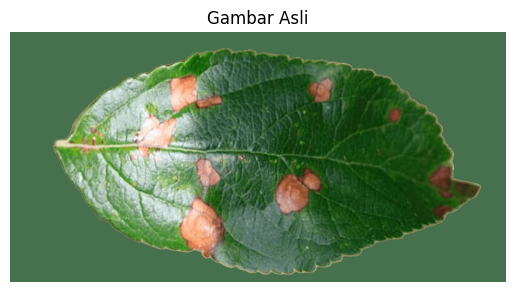

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = list(uploaded.keys())[0]
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

plt.imshow(img_rgb)
plt.title("Gambar Asli")
plt.axis('off')
plt.show()


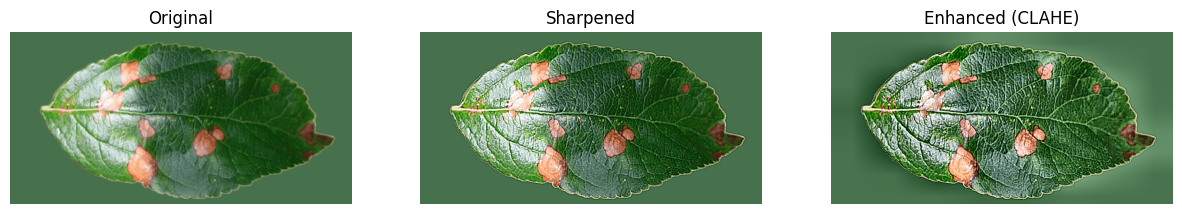

In [35]:
# Gaussian blur untuk mengurangi noise
blurred = cv2.GaussianBlur(img_rgb, (3, 3), 0)

# Sharpening yang lebih kuat
kernel_sharp = np.array([[-1, -1, -1],
                        [-1,  9, -1],
                        [-1, -1, -1]])
sharpened = cv2.filter2D(blurred, -1, kernel_sharp)

# Contrast enhancement menggunakan CLAHE
lab = cv2.cvtColor(sharpened, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
l = clahe.apply(l)
enhanced = cv2.merge([l, a, b])
enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sharpened)
plt.title("Sharpened")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(enhanced)
plt.title("Enhanced (CLAHE)")
plt.axis('off')
plt.show()

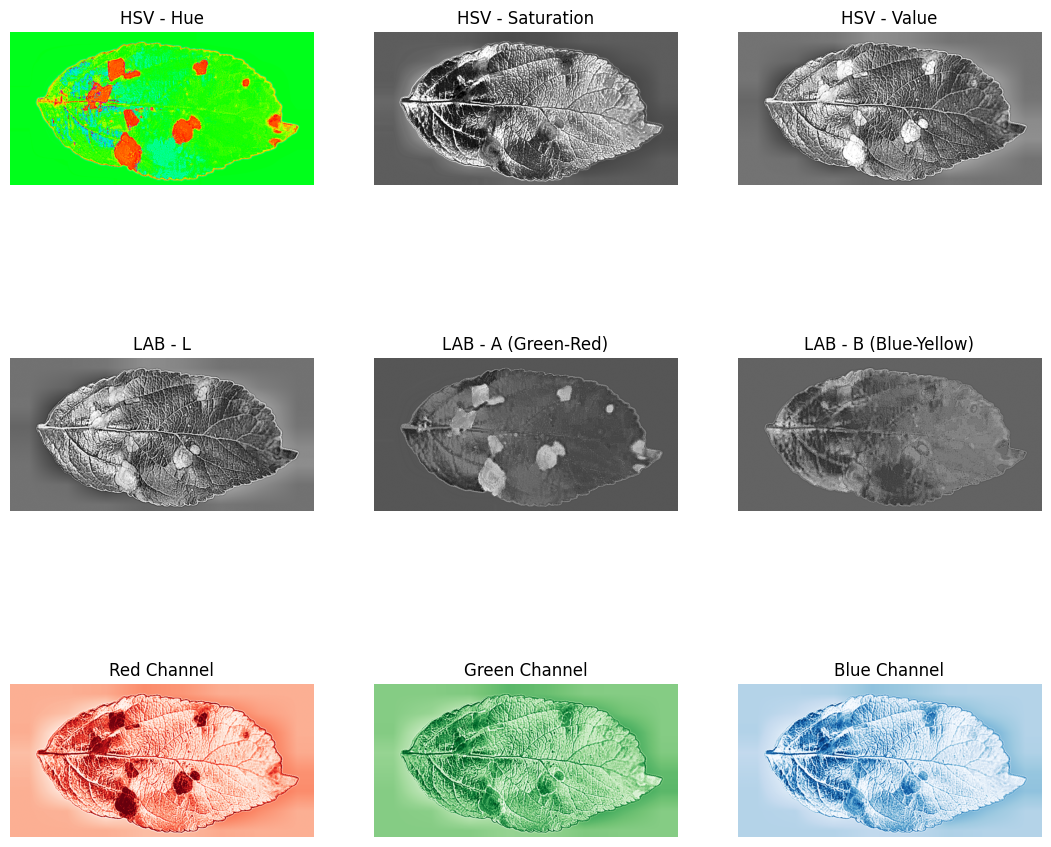

In [36]:
# Convert ke berbagai color space
img_hsv = cv2.cvtColor(enhanced, cv2.COLOR_RGB2HSV)
img_lab = cv2.cvtColor(enhanced, cv2.COLOR_RGB2LAB)
img_yuv = cv2.cvtColor(enhanced, cv2.COLOR_RGB2YUV)

plt.figure(figsize=(18, 12))

# HSV channels
plt.subplot(3, 4, 1)
plt.imshow(img_hsv[:,:,0], cmap='hsv')
plt.title("HSV - Hue")
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(img_hsv[:,:,1], cmap='gray')
plt.title("HSV - Saturation")
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(img_hsv[:,:,2], cmap='gray')
plt.title("HSV - Value")
plt.axis('off')

# LAB channels
plt.subplot(3, 4, 5)
plt.imshow(img_lab[:,:,0], cmap='gray')
plt.title("LAB - L")
plt.axis('off')

plt.subplot(3, 4, 6)
plt.imshow(img_lab[:,:,1], cmap='gray')
plt.title("LAB - A (Green-Red)")
plt.axis('off')

plt.subplot(3, 4, 7)
plt.imshow(img_lab[:,:,2], cmap='gray')
plt.title("LAB - B (Blue-Yellow)")
plt.axis('off')

# RGB channels untuk referensi
plt.subplot(3, 4, 9)
plt.imshow(enhanced[:,:,0], cmap='Reds')
plt.title("Red Channel")
plt.axis('off')

plt.subplot(3, 4, 10)
plt.imshow(enhanced[:,:,1], cmap='Greens')
plt.title("Green Channel")
plt.axis('off')

plt.subplot(3, 4, 11)
plt.imshow(enhanced[:,:,2], cmap='Blues')
plt.title("Blue Channel")
plt.axis('off')

plt.show()


Analyzing color ranges for disease detection...


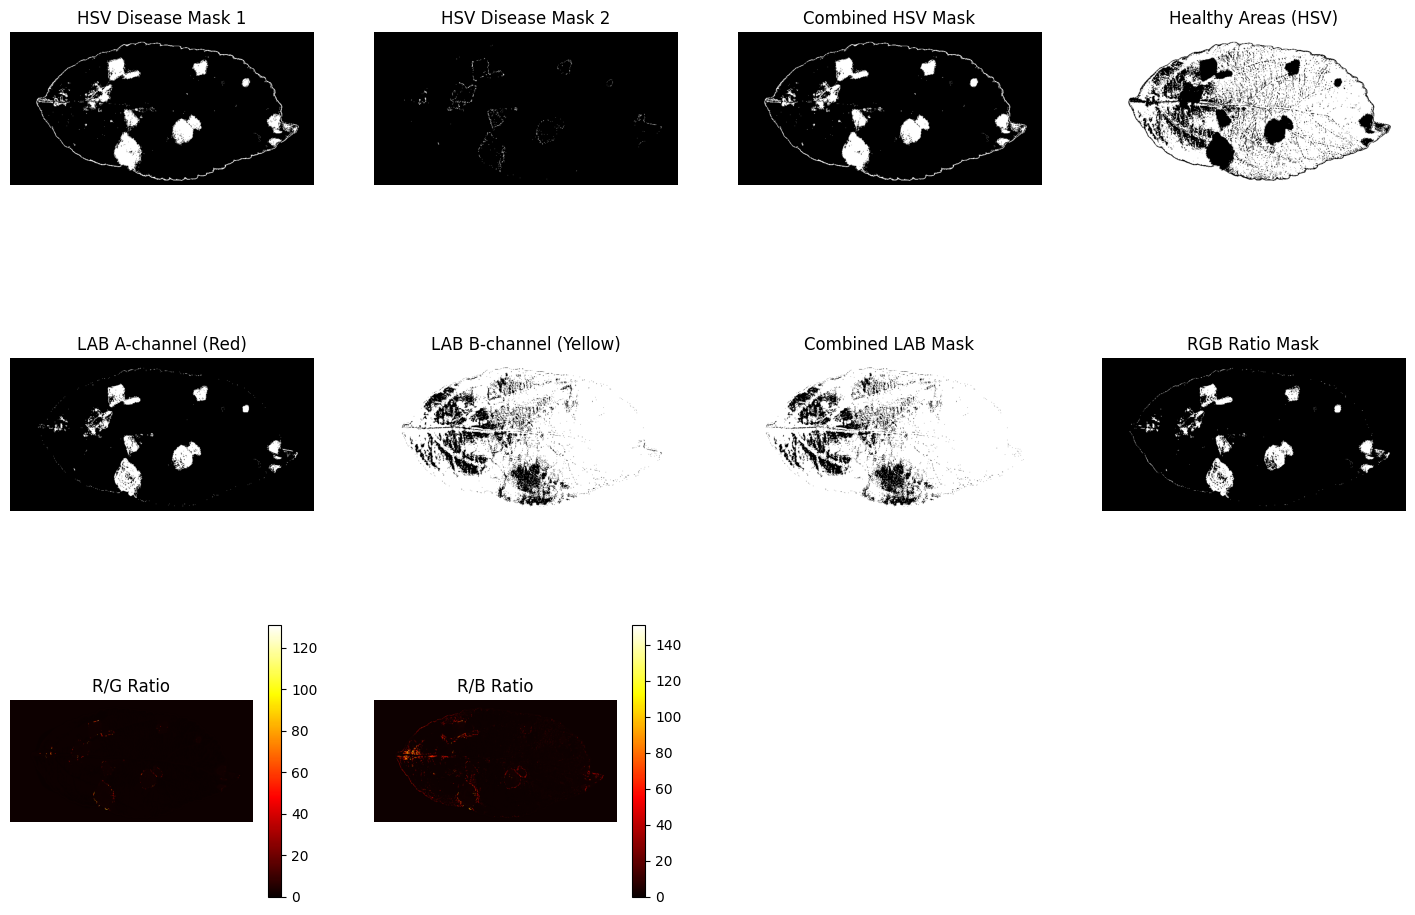

In [37]:
print("Analyzing color ranges for disease detection...")

# Method 1: HSV-based detection dengan range yang lebih luas
# Diseased areas (brownish, reddish, yellowish spots)
lower_disease_hsv1 = np.array([0, 30, 30])     # Red-brown range 1
upper_disease_hsv1 = np.array([30, 255, 255])

lower_disease_hsv2 = np.array([160, 30, 30])   # Red-brown range 2 (wrapping around)
upper_disease_hsv2 = np.array([180, 255, 255])

# Healthy green areas
lower_healthy = np.array([35, 40, 40])
upper_healthy = np.array([85, 255, 255])

# Create masks
disease_mask_hsv1 = cv2.inRange(img_hsv, lower_disease_hsv1, upper_disease_hsv1)
disease_mask_hsv2 = cv2.inRange(img_hsv, lower_disease_hsv2, upper_disease_hsv2)
healthy_mask_hsv = cv2.inRange(img_hsv, lower_healthy, upper_healthy)

# Combine disease masks
disease_mask_hsv = cv2.bitwise_or(disease_mask_hsv1, disease_mask_hsv2)

# Method 2: LAB-based detection
# Dalam LAB space, channel A menunjukkan red-green, B menunjukkan blue-yellow
# Diseased areas biasanya memiliki nilai A tinggi (lebih merah)
lab_a = img_lab[:,:,1]
lab_b = img_lab[:,:,2]

# Threshold untuk area kemerahan (nilai A tinggi)
_, disease_mask_lab_a = cv2.threshold(lab_a, 135, 255, cv2.THRESH_BINARY)

# Threshold untuk area kekuningan (nilai B tinggi)
_, disease_mask_lab_b = cv2.threshold(lab_b, 135, 255, cv2.THRESH_BINARY)

# Gabungkan LAB masks
disease_mask_lab = cv2.bitwise_or(disease_mask_lab_a, disease_mask_lab_b)

# Method 3: RGB ratio-based detection
# Diseased areas biasanya memiliki R > G dan R > B
r_channel = enhanced[:,:,0].astype(np.float32)
g_channel = enhanced[:,:,1].astype(np.float32)
b_channel = enhanced[:,:,2].astype(np.float32)

# Avoid division by zero
g_channel = np.where(g_channel == 0, 1, g_channel)
b_channel = np.where(b_channel == 0, 1, b_channel)

# Calculate ratios
rg_ratio = r_channel / g_channel
rb_ratio = r_channel / b_channel

# Disease detection: R significantly higher than G and B
disease_mask_rgb = np.logical_and(rg_ratio > 1.2, rb_ratio > 1.1).astype(np.uint8) * 255

plt.figure(figsize=(18, 12))

plt.subplot(3, 4, 1)
plt.imshow(disease_mask_hsv1, cmap='gray')
plt.title("HSV Disease Mask 1")
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(disease_mask_hsv2, cmap='gray')
plt.title("HSV Disease Mask 2")
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(disease_mask_hsv, cmap='gray')
plt.title("Combined HSV Mask")
plt.axis('off')

plt.subplot(3, 4, 4)
plt.imshow(healthy_mask_hsv, cmap='gray')
plt.title("Healthy Areas (HSV)")
plt.axis('off')

plt.subplot(3, 4, 5)
plt.imshow(disease_mask_lab_a, cmap='gray')
plt.title("LAB A-channel (Red)")
plt.axis('off')

plt.subplot(3, 4, 6)
plt.imshow(disease_mask_lab_b, cmap='gray')
plt.title("LAB B-channel (Yellow)")
plt.axis('off')

plt.subplot(3, 4, 7)
plt.imshow(disease_mask_lab, cmap='gray')
plt.title("Combined LAB Mask")
plt.axis('off')

plt.subplot(3, 4, 8)
plt.imshow(disease_mask_rgb, cmap='gray')
plt.title("RGB Ratio Mask")
plt.axis('off')

# Show ratio images for debugging
plt.subplot(3, 4, 9)
plt.imshow(rg_ratio, cmap='hot')
plt.title("R/G Ratio")
plt.colorbar()
plt.axis('off')

plt.subplot(3, 4, 10)
plt.imshow(rb_ratio, cmap='hot')
plt.title("R/B Ratio")
plt.colorbar()
plt.axis('off')

plt.show()

Combining all detection methods...


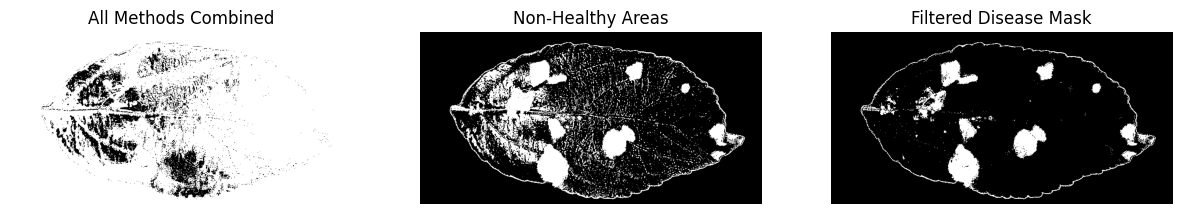

In [38]:
print("Combining all detection methods...")

# Combine all disease detection methods
disease_mask_combined = cv2.bitwise_or(disease_mask_hsv, disease_mask_lab)
disease_mask_combined = cv2.bitwise_or(disease_mask_combined, disease_mask_rgb)

# Remove areas that are clearly healthy (strong green)
disease_mask_filtered = cv2.bitwise_and(disease_mask_combined, cv2.bitwise_not(healthy_mask_hsv))

# Additional filtering: remove areas with too much green
g_dominant = (g_channel > r_channel) & (g_channel > b_channel)
g_dominant_mask = g_dominant.astype(np.uint8) * 255
disease_mask_filtered = cv2.bitwise_and(disease_mask_filtered, cv2.bitwise_not(g_dominant_mask))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(disease_mask_combined, cmap='gray')
plt.title("All Methods Combined")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.bitwise_not(healthy_mask_hsv), cmap='gray')
plt.title("Non-Healthy Areas")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(disease_mask_filtered, cmap='gray')
plt.title("Filtered Disease Mask")
plt.axis('off')
plt.show()

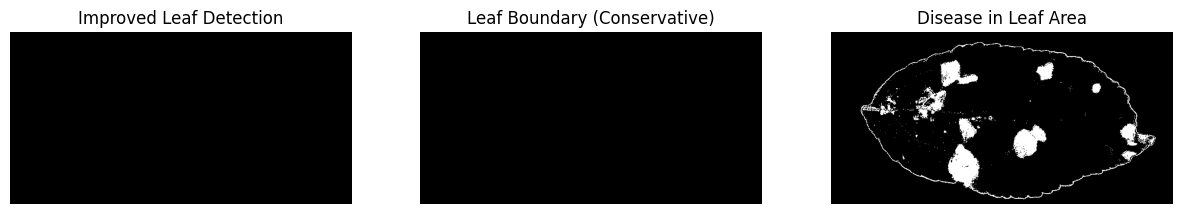

Disease pixels: 22718 -> 22718
Retention: 100.0%


In [39]:
# ===== CELL 7: Improved Leaf Boundary Detection (Simple Version) =====
# Ganti bagian CELL 7 Anda dengan kode ini:

# Method 1: Color-based approach instead of grayscale
img_hsv_leaf = cv2.cvtColor(enhanced, cv2.COLOR_RGB2HSV)

# Lebih inclusive range untuk menangkap semua bagian daun (termasuk yang sakit)
lower_leaf = np.array([20, 15, 15])  # Lebih luas dari range sebelumnya
upper_leaf = np.array([100, 255, 255])

# Create leaf mask
leaf_mask_color = cv2.inRange(img_hsv_leaf, lower_leaf, upper_leaf)

# Method 2: Backup dengan LAB space
img_lab_leaf = cv2.cvtColor(enhanced, cv2.COLOR_RGB2LAB)
l_channel = img_lab_leaf[:,:,0]

# Otsu dengan threshold yang lebih rendah untuk lebih inclusive
ret_val, _ = cv2.threshold(l_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, leaf_mask_lab = cv2.threshold(l_channel, ret_val * 0.6, 255, cv2.THRESH_BINARY)

# Combine both methods
leaf_mask_combined = cv2.bitwise_or(leaf_mask_color, leaf_mask_lab)

# Aggressive morphological operations untuk fill gaps
kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

leaf_mask = cv2.morphologyEx(leaf_mask_combined, cv2.MORPH_CLOSE, kernel_large)
leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_OPEN, kernel_small)
leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_CLOSE, kernel_large)

# Find contours with better filtering
contours, _ = cv2.findContours(leaf_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # Filter contours by area and aspect ratio
    valid_contours = []
    total_area = enhanced.shape[0] * enhanced.shape[1]

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max(500, total_area * 0.05):  # At least 5% of image
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w) / h
            if 0.2 < aspect_ratio < 5.0:  # Reasonable leaf shape
                valid_contours.append(contour)

    if valid_contours:
        largest_contour = max(valid_contours, key=cv2.contourArea)
        leaf_only_mask = np.zeros_like(leaf_mask)
        cv2.fillPoly(leaf_only_mask, [largest_contour], 255)

        # CRITICAL: Dilate mask to ensure we don't lose disease areas at edges
        dilation_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))
        leaf_only_mask = cv2.dilate(leaf_only_mask, dilation_kernel, iterations=3)
    else:
        leaf_only_mask = leaf_mask.copy()
else:
    leaf_only_mask = leaf_mask.copy()

# CONSERVATIVE APPROACH: Don't strictly limit, but enhance
# Create safety zone around existing disease detection
safety_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12, 12))
disease_with_safety = cv2.dilate(disease_mask_filtered, safety_kernel, iterations=2)

# Union approach: Take either leaf boundary OR disease areas (with safety margin)
conservative_mask = cv2.bitwise_or(leaf_only_mask, disease_with_safety)

# Apply conservative boundary
disease_mask_final = cv2.bitwise_and(disease_mask_filtered, conservative_mask)

# Fallback: If we lost too much, use original
original_pixels = cv2.countNonZero(disease_mask_filtered)
new_pixels = cv2.countNonZero(disease_mask_final)

if new_pixels < original_pixels * 0.7:  # Lost more than 30%
    print(f"Boundary detection removed too much ({new_pixels} vs {original_pixels}), using less restrictive approach")
    # Use wider boundary
    wider_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))
    wider_boundary = cv2.dilate(leaf_only_mask, wider_kernel, iterations=3)
    disease_mask_final = cv2.bitwise_and(disease_mask_filtered, wider_boundary)

    # If still too restrictive, use original detection
    if cv2.countNonZero(disease_mask_final) < original_pixels * 0.8:
        print("Using original disease detection without boundary restriction")
        disease_mask_final = disease_mask_filtered.copy()
        leaf_only_mask = np.ones_like(leaf_mask) * 255

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(leaf_mask, cmap='gray')
plt.title("Improved Leaf Detection")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(leaf_only_mask, cmap='gray')
plt.title("Leaf Boundary (Conservative)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(disease_mask_final, cmap='gray')
plt.title("Disease in Leaf Area")
plt.axis('off')
plt.show()

print(f"Disease pixels: {original_pixels} -> {cv2.countNonZero(disease_mask_final)}")
print(f"Retention: {(cv2.countNonZero(disease_mask_final)/max(original_pixels,1))*100:.1f}%")


Found 107 potential disease regions before filtering
Valid disease regions after filtering: 15


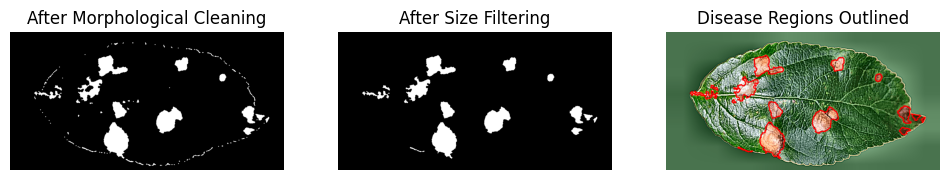

In [40]:
# Clean up the final mask
kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

# Remove small noise
disease_mask_clean = cv2.morphologyEx(disease_mask_final, cv2.MORPH_OPEN, kernel_small)
# Fill small gaps
disease_mask_clean = cv2.morphologyEx(disease_mask_clean, cv2.MORPH_CLOSE, kernel_medium)

# Filter by area size
contours, _ = cv2.findContours(disease_mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 50  # Reduced minimum area untuk menangkap bercak kecil
filtered_mask = np.zeros_like(disease_mask_clean)

print(f"Found {len(contours)} potential disease regions before filtering")
valid_regions = 0

for contour in contours:
    area = cv2.contourArea(contour)
    if area > min_area:
        cv2.fillPoly(filtered_mask, [contour], 255)
        valid_regions += 1

disease_mask_final = filtered_mask
print(f"Valid disease regions after filtering: {valid_regions}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(disease_mask_clean, cmap='gray')
plt.title("After Morphological Cleaning")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(disease_mask_final, cmap='gray')
plt.title("After Size Filtering")
plt.axis('off')

# Show original with detected regions outlined
img_with_contours = enhanced.copy()
if valid_regions > 0:
    contours_final, _ = cv2.findContours(disease_mask_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img_with_contours, contours_final, -1, (255, 0, 0), 2)

plt.subplot(1, 3, 3)
plt.imshow(img_with_contours)
plt.title("Disease Regions Outlined")
plt.axis('off')
plt.show()

In [41]:
# Calculate disease percentage
if contours and len(contours) > 0:
    # Use leaf area as reference
    leaf_contours, _ = cv2.findContours(leaf_only_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if leaf_contours:
        largest_leaf_contour = max(leaf_contours, key=cv2.contourArea)
        leaf_area = cv2.contourArea(largest_leaf_contour)
    else:
        leaf_area = cv2.countNonZero(leaf_only_mask)

    sick_pixels = cv2.countNonZero(disease_mask_final)
    if leaf_area > 0:
        percent_sick = (sick_pixels / leaf_area) * 100
    else:
        percent_sick = 0
else:
    total_pixels = enhanced.shape[0] * enhanced.shape[1]
    sick_pixels = cv2.countNonZero(disease_mask_final)
    percent_sick = (sick_pixels / total_pixels) * 100
    leaf_area = total_pixels

print(f"Leaf area: {leaf_area} pixels")
print(f"Sick pixels: {sick_pixels}")
print(f"Disease percentage: {percent_sick:.2f}%")

# Classify severity
if percent_sick < 2:
    severity = "Very Light"
    color = "lightgreen"
elif percent_sick < 8:
    severity = "Light"
    color = "green"
elif percent_sick < 20:
    severity = "Moderate"
    color = "yellow"
elif percent_sick < 40:
    severity = "Severe"
    color = "orange"
else:
    severity = "Very Severe"
    color = "red"

print(f"Severity: {severity}")

Leaf area: 316407.0 pixels
Sick pixels: 18975
Disease percentage: 6.00%
Severity: Light


(np.float64(-0.5), np.float64(793.5), np.float64(399.5), np.float64(-0.5))

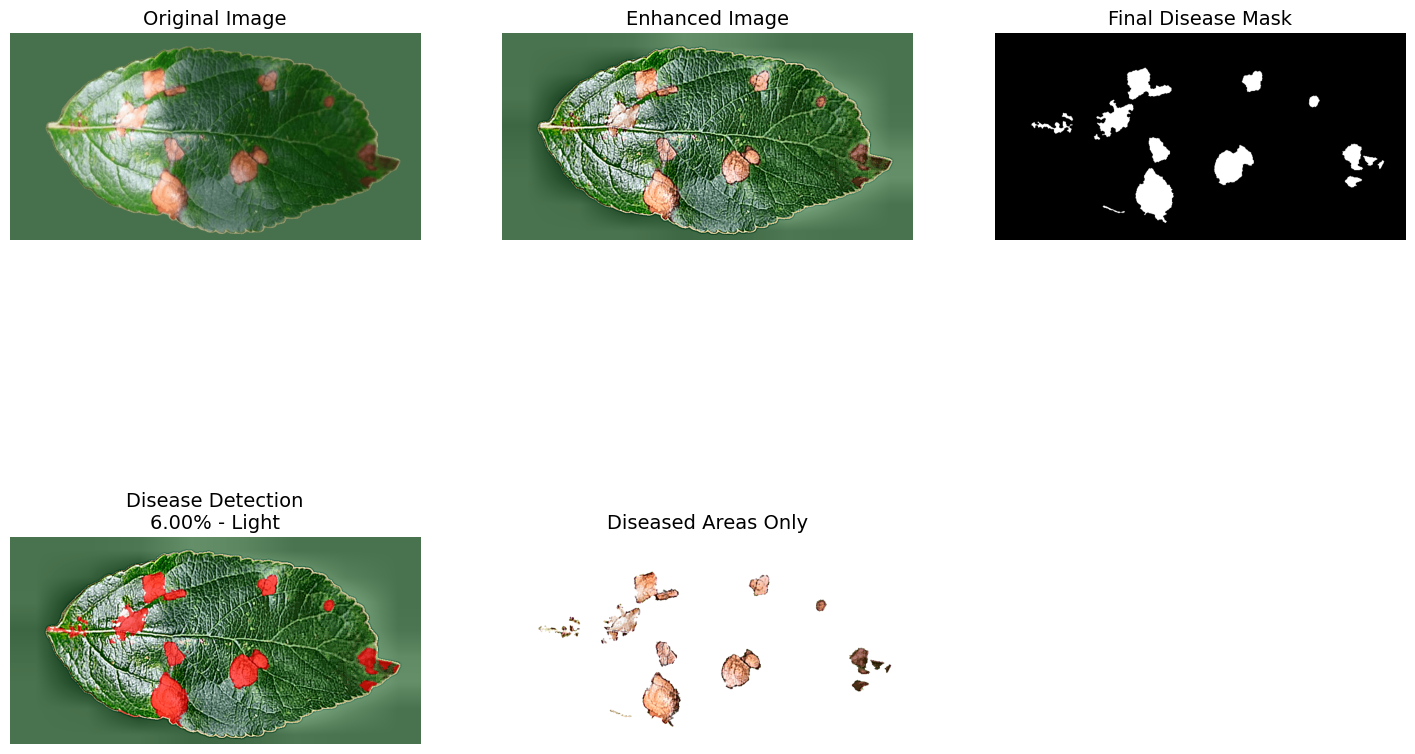

In [45]:
# Create final overlay
overlay = enhanced.copy()
overlay[disease_mask_final > 0] = [255, 0, 0]  # Red for diseased areas

# Blend with original
alpha = 0.6
output = cv2.addWeighted(enhanced, 1-alpha, overlay, alpha, 0)

# Create diseased areas only image
diseased_only = enhanced.copy()
diseased_only[disease_mask_final == 0] = [255, 255, 255]  # White background

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.imshow(img_rgb)
plt.title("Original Image", fontsize=14)
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(enhanced)
plt.title("Enhanced Image", fontsize=14)
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(disease_mask_final, cmap='gray')
plt.title("Final Disease Mask", fontsize=14)
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(output)
plt.title(f"Disease Detection\n{percent_sick:.2f}% - {severity}", fontsize=14)
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(diseased_only)
plt.title("Diseased Areas Only", fontsize=14)
plt.axis('off')
